# Davos Data Project

# Goal:
## Generate data to support a story that demonstrates the value of Gecko's unique dataset


**Hypotheses:**
- Extreme Weather leads to outages due to increased energy demand and stress on the grid
    - Winter weather events , extreme cold
    - Summer and extreme heat
- What is the current state of US boilers, Gecko has inspected many recently, are they in good shape ?  How do we define good shape ?

# Table of Contents:

1. Data Overview
    - data
2. Environment Setup
3. Data Loading & Preprocessing
4. EDA & Visualization

# 1. Data Overview

- data
    - raw_data
        1. **AEP Plants 2011-20220802 Boiler Tube Leaks.xlsx**
            - AEP boiler tube leaks Jan 2011 - Aug 2022
            - Source: AEP, Wolpa
        2. **Duke Fleet Boiler tube failure data 2005 - 2020.csv**
            - Duke boiler tube leaks 2005 - 2020
            - Source: Duke, Connor
        3. **All US Boilers.csv**
            - US Boilers
            - Source: IIR, Wolpa
        - **salesforce.csv**
            - Gecko Salesforce data
            - Source: Gecko Salesforce
        - **portalservice_power_units**
            - all power industry units in portal data
            - Source: Gecko portal-service

# 2. Environment Setup

In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import sys
sys.path.insert(0, '..')
import warnings
import zlib

# local
from libs.etl.data_cleaning import generate_aep_outage_dfs, generate_duke_outage_dfs, generate_iir_boilers_dfs, determine_component
from libs.inspection_analysis.utils import analyze_inspection_df, hist_inspection_df, check_thickness, get_thickness_histogram, group_critdat, get_inspection_df
from libs.reference.constants import COMPONENT_TYPE_MAP, POWER_CUST_LIST
from libs.viz.utils import add_vbar_labels, add_hbar_labels

Matplotlib Style:

In [2]:
plt.style.use('dark_background')
#sns.set_style('darkgrid')

Get Current Working Directory:

In [3]:
wd = os.getcwd()
print(wd)

C:\Users\tom.fiorelli\Documents\GitHub\davos-data-project\notebooks


Pandas Settings:

In [4]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

Disable Warnings:

In [5]:
warnings.filterwarnings('ignore')

Set Token ?

In [6]:
# token = """eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCIsImtpZCI6IkVpeTN0a0l0bzZ0SDFTZ1VZdUdXVCJ9.eyJpc3MiOiJodHRwczovL2dlY2tvcm9ib3RpY3MudXMuYXV0aDAuY29tLyIsInN1YiI6Imdvb2dsZS1vYXV0aDJ8MTAxODIxNjU3MzQ0ODI0ODQxMjA5IiwiYXVkIjpbImNsb3VkLmdlY2tvcm9ib3RpY3MuY29tIiwiaHR0cHM6Ly9nZWNrb3JvYm90aWNzLnVzLmF1dGgwLmNvbS91c2VyaW5mbyJdLCJpYXQiOjE2NzM5NzE1NzYsImV4cCI6MTY3NDA1Nzk3NiwiYXpwIjoiSm1la3lLS0RsM2liRzdQbExRY2JLWHZoekx1UTRaQ08iLCJzY29wZSI6Im9wZW5pZCBwcm9maWxlIGVtYWlsIiwicGVybWlzc2lvbnMiOlsiY29sbGVjdGlvbnM6M2RfbW9kZWxzOmVkaXQiLCJjb2xsZWN0aW9uczphZG5vYy1hYnUtZGhhYmktbmF0aW9uYWwtb2lsLWNvbXBhbnktMmE1MzY0OmVkaXQiLCJjb2xsZWN0aW9uczphZXAtYTgyZjE4OmVkaXQiLCJjb2xsZWN0aW9uczphZXMtZWE0ZjMwOmVkaXQiLCJjb2xsZWN0aW9uczpiYXNmLTBmMmNiZTplZGl0IiwiY29sbGVjdGlvbnM6Y2hldnJvbi0wMWE1M2Y6ZWRpdCIsImNvbGxlY3Rpb25zOmNvbWJpbmVkX2NvbXBvbmVudF9kZnM6ZWRpdCIsImNvbGxlY3Rpb25zOmRvbXRhci03NDVhNWE6ZWRpdCIsImNvbGxlY3Rpb25zOmR1a2UtN2YyZmFmOmVkaXQiLCJjb2xsZWN0aW9uczplYmVuc2J1cmctcG93ZXItY29tcGFueS0wZTEyMWY6ZWRpdCIsImNvbGxlY3Rpb25zOmV4eG9uLTdmZDJhYjplZGl0IiwiY29sbGVjdGlvbnM6ZmRlLWRlbW86ZWRpdCIsImNvbGxlY3Rpb25zOmdlb3JnaWEtcGFjaWZpYy1hMWVjNTM6ZWRpdCIsImNvbGxlY3Rpb25zOm1hbnVhbF9pbnNwZWN0aW9uczplZGl0IiwiY29sbGVjdGlvbnM6bm9uc3BlY2lmaWMtY3VzdG9tZXI6ZWRpdCIsImNvbGxlY3Rpb25zOnJvbGxvdXRfaW1hZ2VzOmVkaXQiLCJjb2xsZWN0aW9uczp1cy1uYXZ5LTY5YTcyYTplZGl0IiwiZ2Vja286cmVhZCIsImdlY2tvOnJvbG9kZXg6ZWRpdCJdfQ.k5CJ5-EnyS1ELVIoCtNFqVrYRYuqVsKYdG5_nWqAXxgBcSS-qhiVr-RXpLyX3FLG2BYSrg0qUA8fet27LB7hMUt8wBnFNwFBlHAUbv0xYvyn2zLrxSWMxUIPI5vr6MVRKbJwPpPYVA-uOmM3idW8sWVs3RR544WZUC29Nt73zThAap2LG9qG-UrAJGOo9U365uFKkANH_A69qySfMUnQ7SGrSuuXNP0f8xXPmn4LQ63zJ_kVDEQNNQD-LhQo6ynMVG28h9UhoQ39MPvz-yRJLYKBk45QfQPk1yCqXWTwKKUg4_UyNy-JyaEbTWU3CW_Y47mlqVu5HZHWOWbTE3cb7A"""

# 3. EDA and Visualization

## Source 1:
AEP Plants 2011-20220802 Boiler Tube Leaks.xlsx

Description:

This dataset contains a large set of AEP tube failures across their steam fleet for a number of years

In [7]:
# get data
aep_df, active_aep_df = generate_aep_outage_dfs()

In [8]:
aep_df.shape

(2195, 18)

In [9]:
active_aep_df.shape

(1473, 18)

In [10]:
aep_df.head(1)

,Utility Name,Plant Name,Unit Name,Event Start Timestamp,Event End Timestamp,Event Type Code,Event Number,System Name,Component Name,Cause Code,Cause Description,Retired Flag,v_Event_Reduction,NERC Equivalent Hours,NERC MWH Loss,Unnamed: 15,Outage Month,Outage Week
0,AEP West Southwestern Electric Power Co,Pirkey,Pirkey 1,2010-12-31 03:19:59.999,2011-01-02 00:12:00,U1,123.0,Boiler,Boiler Tube Leaks,1000,Waterwall (Furnace wall),N,675.0,24.2,16335.0,Keep,12,52


In [11]:
active_aep_df.head(1)

,Utility Name,Plant Name,Unit Name,Event Start Timestamp,Event End Timestamp,Event Type Code,Event Number,System Name,Component Name,Cause Code,Cause Description,Retired Flag,v_Event_Reduction,NERC Equivalent Hours,NERC MWH Loss,Unnamed: 15,Outage Month,Outage Week
0,AEP West Southwestern Electric Power Co,Pirkey,Pirkey 1,2010-12-31 03:19:59.999,2011-01-02 00:12:00,U1,123.0,Boiler,Boiler Tube Leaks,1000,Waterwall (Furnace wall),N,675.0,24.2,16335.0,Keep,12,52


In [12]:
set(aep_df['System Name'])

{'Boiler', 'HRSG Boiler', 'Heat Recovery Steam Generator (HRSG)'}

In [13]:
active_aep_df['Event Start Timestamp'].min()

Timestamp('2010-12-31 03:19:59.999000')

In [14]:
active_aep_df['Event Start Timestamp'].max()

Timestamp('2022-06-25 06:25:00')

In [15]:
active_aep_df['Plant Name'].nunique()

26

In [16]:
active_aep_df['Unit Name'].nunique()

57

In [17]:
component_df = active_aep_df.groupby(['Cause Description'])['Event Start Timestamp'].nunique().to_frame().sort_values(by='Event Start Timestamp', ascending=False).reset_index()

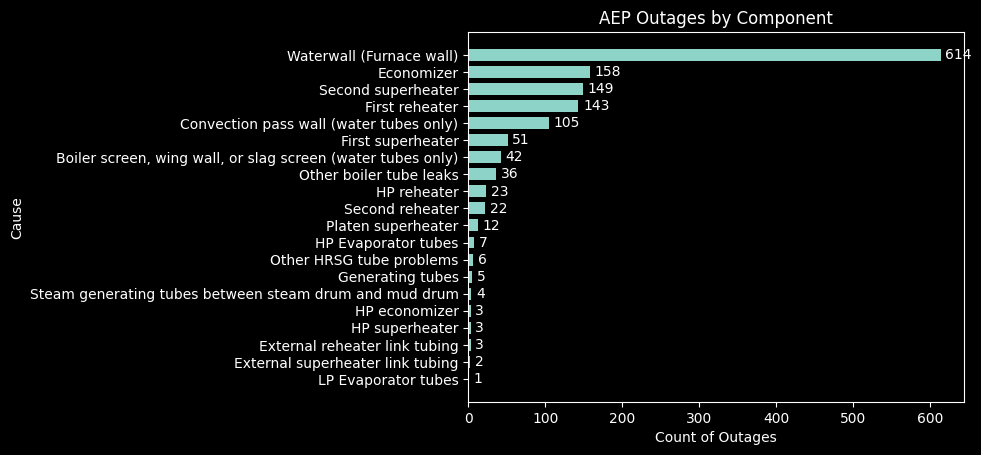

In [18]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,5)

x = component_df["Cause Description"]
y = component_df["Event Start Timestamp"]
width =0.7

rects1 = ax.barh(x, y, width, label = 'Outages')
ax.set_title('AEP Outages by Component')
ax.set_ylabel('Cause')
ax.set_xlabel('Count of Outages')

add_hbar_labels(x, y)

#ax.set_xticks(x)
#ax.set_xticklabels(component_df["Cause Description"])
#ax.legend()

ax.invert_yaxis()

#fig.tight_layout()

#plt.xticks(rotation=90)
plt.show()

In [19]:
aep_month_outage_df = active_aep_df.groupby(['Outage Month'])['Event Start Timestamp'].nunique().to_frame().reset_index()

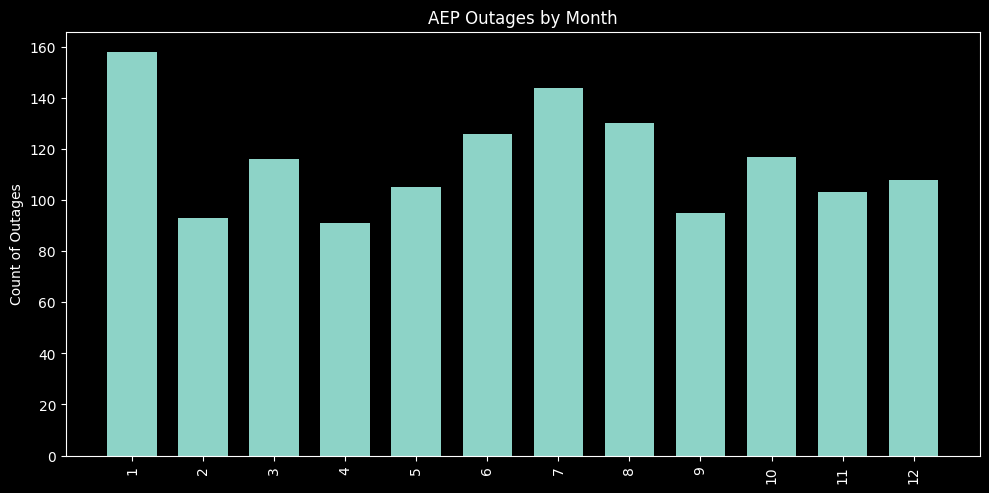

In [20]:
fig, ax = plt.subplots()

x = aep_month_outage_df["Outage Month"]
y = aep_month_outage_df["Event Start Timestamp"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Outages')
ax.set_title('AEP Outages by Month')
ax.set_ylabel('Count of Outages')
ax.set_xticks(x)
ax.set_xticklabels(aep_month_outage_df["Outage Month"])
#ax.legend()

#add_vbar_labels(x,y)

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [21]:
plant_outages_df = active_aep_df.groupby(['Plant Name'])['Event Start Timestamp'].nunique().to_frame().reset_index().sort_values(by='Event Start Timestamp', ascending=False)

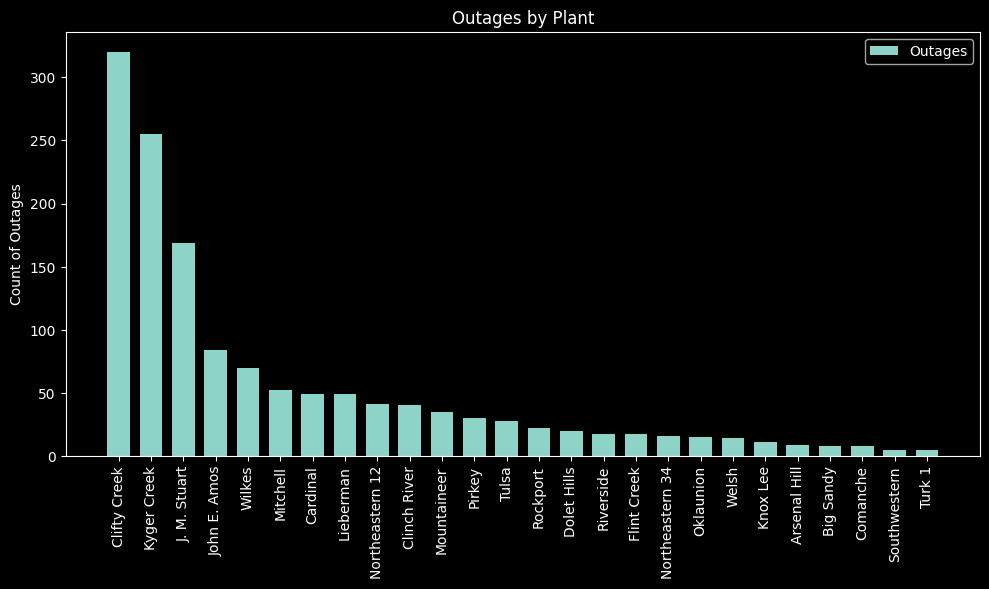

In [22]:
fig, ax = plt.subplots()

x = plant_outages_df["Plant Name"]
y = plant_outages_df["Event Start Timestamp"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Outages')
ax.set_title('Outages by Plant')
ax.set_ylabel('Count of Outages')
ax.set_xticks(x)
ax.set_xticklabels(plant_outages_df["Plant Name"])
ax.legend()

# add_vbar_labels(x,y)

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [23]:
outage_duration_df = active_aep_df.groupby(['Plant Name'])['NERC Equivalent Hours'].sum().to_frame().reset_index().sort_values(by='NERC Equivalent Hours', ascending=False)

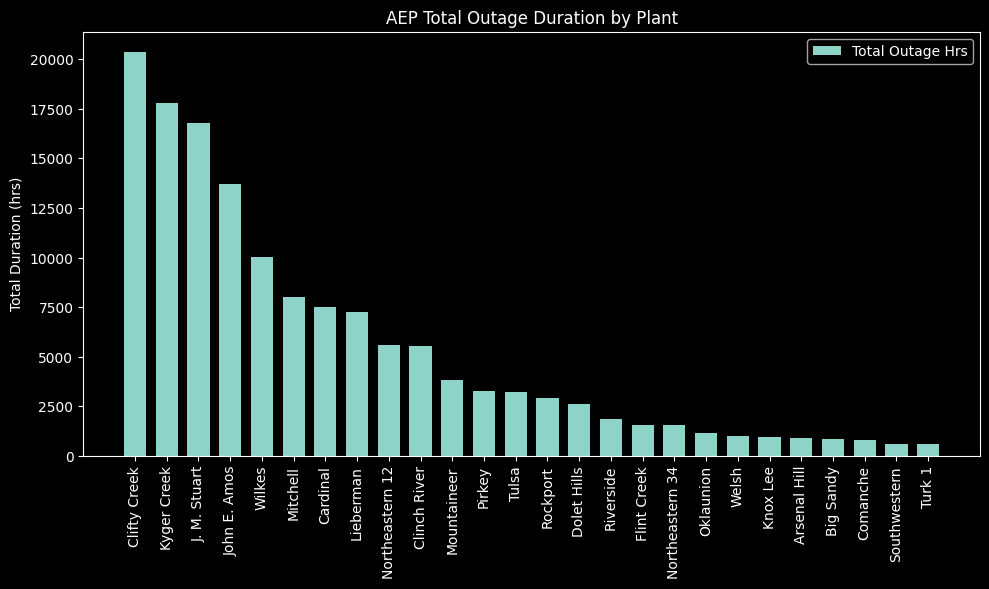

In [24]:
fig, ax = plt.subplots()

x = outage_duration_df["Plant Name"]
y = outage_duration_df["NERC Equivalent Hours"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Total Outage Hrs')
ax.set_title('AEP Total Outage Duration by Plant')
ax.set_ylabel('Total Duration (hrs)')
ax.set_xticks(x)
ax.set_xticklabels(plant_outages_df["Plant Name"])
ax.legend()

# add_vbar_labels(x,y)

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [25]:
outage_mwh_df = active_aep_df.groupby(['Plant Name'])['NERC MWH Loss'].sum().to_frame().reset_index().sort_values(by='NERC MWH Loss', ascending=False)

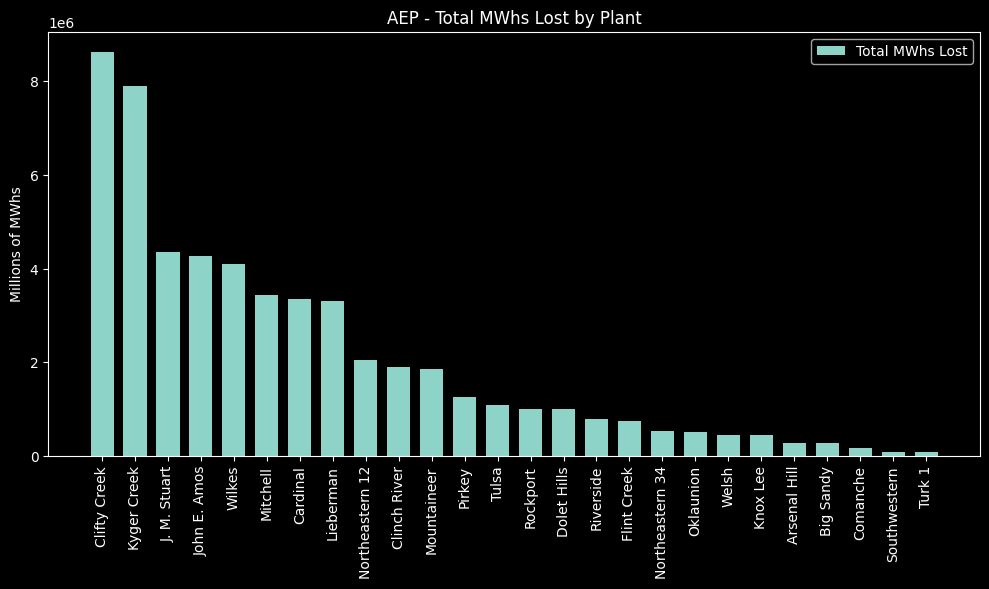

In [26]:
fig, ax = plt.subplots()

x = outage_mwh_df["Plant Name"]
y = outage_mwh_df["NERC MWH Loss"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Total MWhs Lost')
ax.set_title('AEP - Total MWhs Lost by Plant')
ax.set_ylabel('Millions of MWhs')
ax.set_xticks(x)
ax.set_xticklabels(plant_outages_df["Plant Name"])
ax.legend()

#add_vbar_labels(x,y)

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

## Source 2:
Duke Fleet Boiler tube failure data 2005 - 2020.csv

In [27]:
duke_df = generate_duke_outage_dfs()

In [28]:
duke_df.shape

(1184, 8)

In [29]:
duke_df.head()

,Event ID,Station-Unit,Start Date,Cause Code Name,IsRepeat,TimeBetweenFailure,Outage Month,Outage Week
0,31289,East Bend Steam-2,1/4/05 9:41,Waterwall (Furnace wall) A,False,NaN,1,1
1,31290,East Bend Steam-2,1/4/05 10:23,Waterwall (Furnace wall) A,True,0.700000,1,1
2,34085,Gibson Steam-3,1/14/05 11:31,Waterwall (Furnace wall) A,False,NaN,1,2
3,34086,Gibson Steam-3,1/14/05 14:11,Waterwall (Furnace wall) A,True,2.666667,1,2
4,34087,Gibson Steam-3,1/16/05 2:41,Waterwall (Furnace wall) A,True,36.500000,1,2


In [30]:
duke_month_outages_df = duke_df.groupby(['Outage Month'])['Event ID'].nunique().to_frame().reset_index()

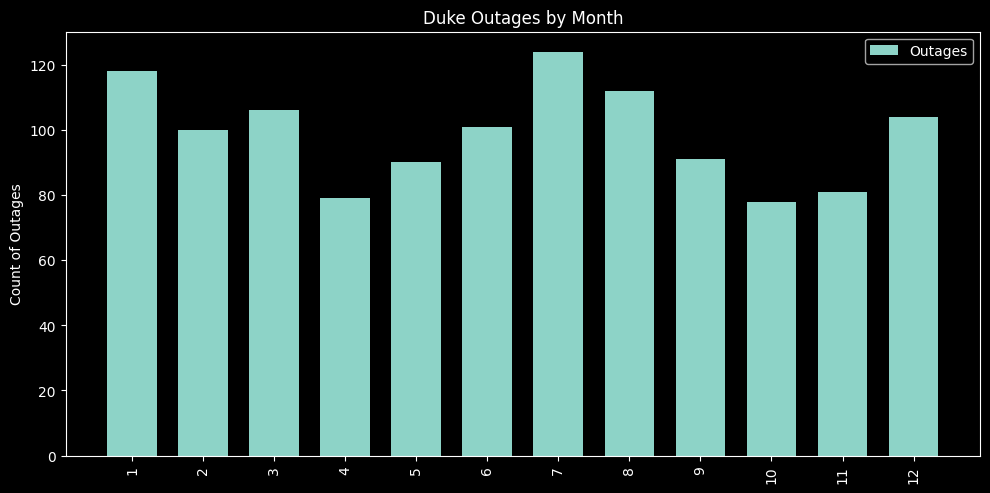

In [31]:
fig, ax = plt.subplots()

x = duke_month_outages_df["Outage Month"]
y = duke_month_outages_df["Event ID"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Outages')
ax.set_title('Duke Outages by Month')
ax.set_ylabel('Count of Outages')
ax.set_xticks(x)
ax.set_xticklabels(duke_month_outages_df["Outage Month"])
ax.legend()

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [32]:
duke_station_unit_df = duke_df.groupby(['Station-Unit'])['Event ID'].nunique().to_frame().reset_index().sort_values(by=['Event ID'], ascending=False)

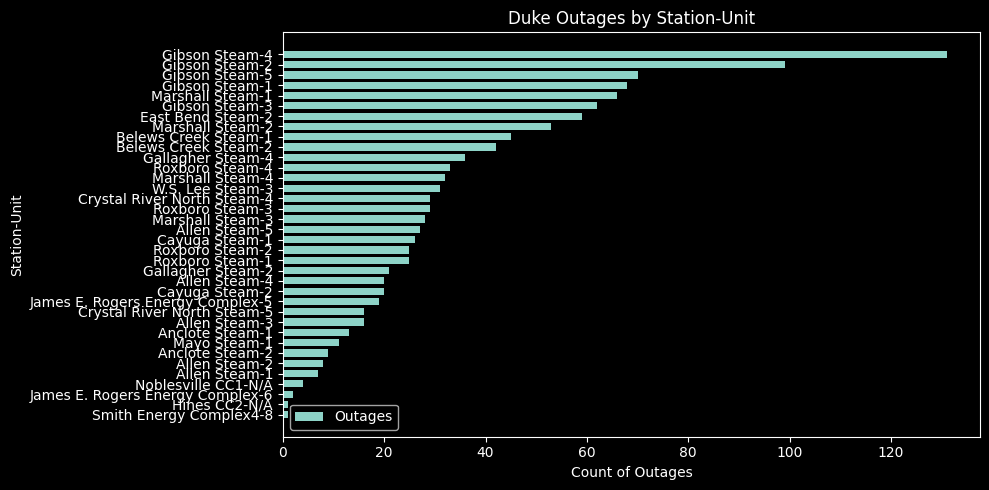

In [33]:
fig, ax = plt.subplots()

x = duke_station_unit_df["Station-Unit"]
y = duke_station_unit_df["Event ID"]
width =0.7

rects1 = ax.barh(x, y, width, label = 'Outages')
ax.set_title('Duke Outages by Station-Unit')
ax.set_ylabel('Station-Unit')
#ax.set_xticks(x)
#ax.set_xticklabels(duke_station_unit_df["Station-Unit"])
ax.legend()
ax.set_xlabel('Count of Outages')

ax.invert_yaxis()

fig.tight_layout()

#plt.xticks(rotation=90)
plt.show()

## Source 3:
All US Boilers.csv

In [34]:
us_boilers_df, operational_us_boilers_df = generate_iir_boilers_dfs()

### NOTES:

OUT_DESIGN is in MW

avg 5days per outage

heat rate , lower is better

In [35]:
us_boilers_df.head(10)

,PARENTNAME,OWNER_NAME,OPER_NAME,PLANT_NAME,PHYS_CITY,P_COUNTY,UNIT_STATE,P_ST_NAME,P_COUNTRY,MARKET_REG,WORLD_REG,IND_CODE_DESC,SIC_CODE,PLANT_ID,UNIT_NAME,UNIT_ID,UNIT_TYPE,OUT_DESIGN,KO_DATE,STARTUP,STARTYEAR,SHUTDOWN,PRIM_FUEL,SECND_FUEL,FUEL_GROUP,HEAT_RATE,PWR_USAGE,U_STATUS,BOIL_NAME,BOILERTYPE,BMFR_NAME,BOIL_INFO,STEAM,STEAM_UOM,STEAM_TON,PRESSURE,PRES_UOM,PRES_BAR,TEMP,TEMP_UOM,TEMP_CEL,DESIGNFIRM,CONSTFIRM,MMBTU_HR,KO_YEAR,LATITUDE,LONGITUDE,COGEN_CHP,SHUTDOWN_dt,SHUTDOWN_yr,BOIL_CONFIG,BOIL_TYPE_Tag,Criticality
0,The Blackstone Group Incorporated,Lightstone Generation LLC,Lightstone Generation LLC,James Gavin Power Station,Cheshire,Gallia,OH,Ohio,U.S.A.,Great Lakes,North America,Power,4911,1010019,James Gavin 02,1003920,Steam Turbine,1300.0,NaN,1-Jul-75,1975,1-Dec-35,Coal Bituminous,Fuel Oil No. 2 Distillate Diesel,Coal,9799.0,Base Load,Operational,Boiler 02,Dry Bottom Boiler,Babcock & Wilcox,Opposed-Fired SCR LNB ESP-CS FGD-WS Trona,9775000.0,lbs/hr,4887.5,3685.0,PSIG,254.0,1010.0,deg F,543.0,AEP Pro Serv,AEP Pro Serv,NaN,NaN,38.934700,-82.115800,0,2035-12-01,2035.0,Opposed,Unknown,none
1,American Electric Power Company Incorporated,Appalachian Power Company,Appalachian Power Company,John Amos Power Station,Winfield,Putnam,WV,West Virginia,U.S.A.,Mid Atlantic,North America,Power,4911,1516038,John E Amos 03,1007895,Steam Turbine,1300.0,NaN,1-Oct-73,1973,1-Dec-33,Coal Bituminous,Fuel Oil No. 2 Distillate Diesel,Coal,9597.0,Intermediate Load,Operational,Boiler 03,Dry Bottom Boiler,Babcock & Wilcox,UP-101 PC Opposed-Fired SCR LNB ESP-CS (FGD-WS...,9775000.0,lbs/hr,4887.5,3700.0,PSIG,255.0,1000.0,deg F,538.0,American Electric Power,American Electric Power,11936.0,NaN,38.473069,-81.822458,0,2033-12-01,2033.0,Opposed,PC,none
2,Tennessee Valley Authority,Tennessee Valley Authority,Tennessee Valley Authority,Cumberland Fossil Power Station,Cumberland City,Stewart,TN,Tennessee,U.S.A.,Southeast,North America,Power,4911,1012869,Cumberland 01,1003702,Steam Turbine,1300.0,1-Jan-68,1-Mar-73,1973,31-Dec-28,Coal Bituminous,NaN,Coal,9678.0,Base Load,Operational,Boiler 01,Dry Bottom Boiler,Babcock & Wilcox,PC Opposed-Fired LNB SCR ESP-CS FGD-WS,9300000.0,lbs/hr,4650.0,3500.0,PSIG,241.0,1003.0,deg F,539.0,Black & Veatch,NaN,NaN,1968.0,36.391944,-87.655555,0,2028-12-31,2028.0,Opposed,PC,none
3,Tennessee Valley Authority,Tennessee Valley Authority,Tennessee Valley Authority,Cumberland Fossil Power Station,Cumberland City,Stewart,TN,Tennessee,U.S.A.,Southeast,North America,Power,4911,1012869,Cumberland 02,1003703,Steam Turbine,1300.0,1-Jan-68,1-Nov-73,1973,31-Dec-26,Coal Bituminous,NaN,Coal,9678.0,Intermediate Load,Operational,Boiler 02,Dry Bottom Boiler,Babcock & Wilcox,PC Opposed-Fired ESP LNB SCR FGD-WS,9300000.0,lbs/hr,4650.0,3500.0,PSIG,241.0,1003.0,deg F,539.0,Black & Veatch,NaN,NaN,1968.0,36.391944,-87.655555,0,2026-12-31,2026.0,Opposed,PC,none
4,The Blackstone Group Incorporated,Lightstone Generation LLC,Lightstone Generation LLC,James Gavin Power Station,Cheshire,Gallia,OH,Ohio,U.S.A.,Great Lakes,North America,Power,4911,1010019,James Gavin 01,1003919,Steam Turbine,1300.0,NaN,1-Oct-74,1974,1-Dec-35,Coal Bituminous,Fuel Oil No. 2 Distillate Diesel,Coal,9799.0,Base Load,Operational,Boiler 01,Dry Bottom Boiler,Babcock & Wilcox,Opposed-Fired SCR LNB ESP-CS FGD-WS Trona,9775000.0,lbs/hr,4887.5,3685.0,PSIG,254.0,1010.0,deg F,543.0,Black & Veatch,NaN,NaN,NaN,38.934700,-82.115800,0,2035-12-01,2035.0,Opposed,Unknown,none
5,American Electric Power Company Incorporated,Appalachian Power Company,Appalachian Power Company,Mountaineer Power Station,New Haven,Mason,WV,West Virginia,U.S.A.,Mid Atlantic,North America,Power,4911,1013868,Mountaineer 01,1007883,Steam Turbine,1300.0,NaN,1-Sep-80,1980,NaN,Coal Bituminous,Fuel Oil No. 2 Distillate Diesel,Coal,9403.0,Base Load,Operational,Boiler 01,Dry Bottom Boiler,Babcock & Wilcox,UP-108 PC Opposed-Fired OFA LNB SCR ESP-CS FGD...,9775000.0,lbs/hr,4887.5,3845.0,PSIG,265.0,1010.0,deg F,543.0,American E

In [36]:
# us_boilers_df[us_boilers_df['PLANT_NAME'].str.contains('Petersburg')]

In [37]:
operational_boilers_usage = operational_us_boilers_df.groupby(['PWR_USAGE'])['UNIT_ID'].nunique().to_frame().reset_index()

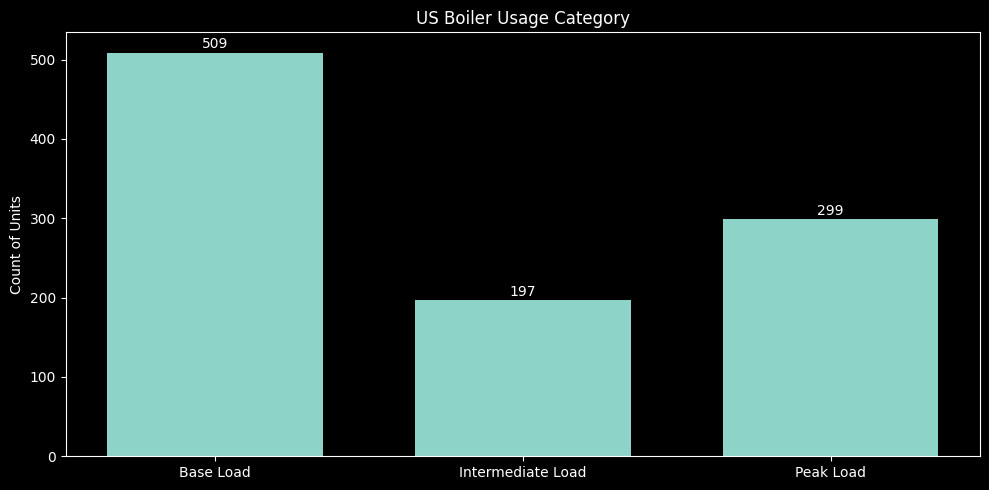

In [38]:
fig, ax = plt.subplots()

x = operational_boilers_usage["PWR_USAGE"]
y = operational_boilers_usage["UNIT_ID"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Status')
ax.set_title('US Boiler Usage Category')
ax.set_ylabel('Count of Units')
ax.set_xticks(x)
#ax.set_xticklabels(x)
#ax.legend()

add_vbar_labels(x,y)

fig.tight_layout()

#plt.axvline(x=2023, c='r')
#plt.xticks(np.arange(min(x), max(x)+1, 5))

#plt.xticks(rotation=45)
plt.show()

In [39]:
operational_boilers_fuel = operational_us_boilers_df.groupby(['PRIM_FUEL'])['UNIT_ID'].nunique().to_frame().reset_index().sort_values(by=['UNIT_ID'], ascending=False)

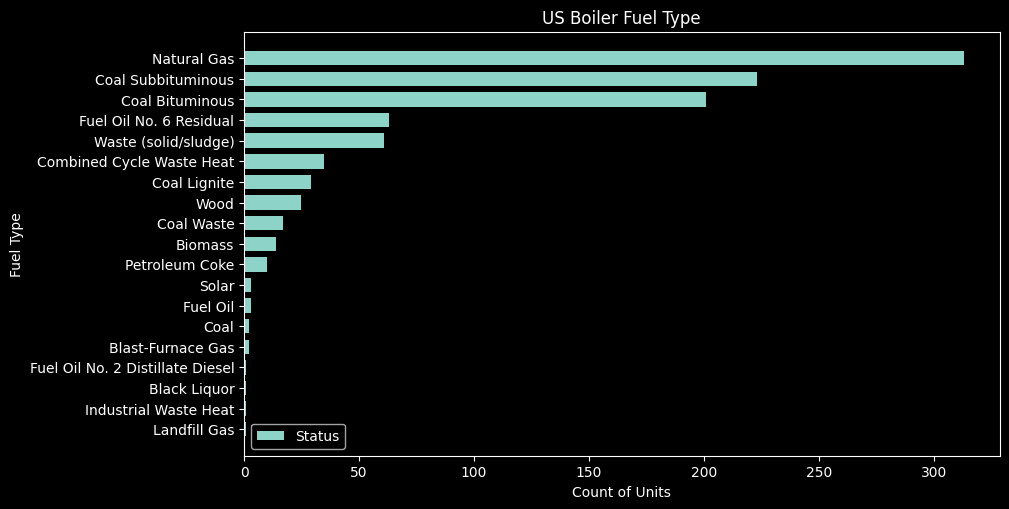

In [40]:
fig, ax = plt.subplots()

x = operational_boilers_fuel["PRIM_FUEL"]
y = operational_boilers_fuel["UNIT_ID"]
width =0.7

rects1 = ax.barh(x, y, width, label = 'Status')
ax.set_title('US Boiler Fuel Type')

#ax.set_xticklabels(x)
ax.legend()

fig.tight_layout()

ax.invert_yaxis()

ax.set_ylabel('Fuel Type')
ax.set_xlabel('Count of Units')
#ax.set_xticks(x)

#plt.axvline(x=2023, c='r')
#plt.xticks(np.arange(min(x), max(x)+1, 5))

#plt.xticks(rotation=90)
plt.show()

In [41]:
set(us_boilers_df['MARKET_REG'])

{'Atlantic Canada',
 'Great Lakes',
 'Mid Atlantic',
 'Midwest',
 'New England',
 'Northeast',
 'Ontario',
 'Rocky Mountains',
 'Southeast',
 'Southwest',
 'West Coast',
 'Western Canada'}

In [42]:
us_boilers_df.groupby(['MARKET_REG', 'PARENTNAME', 'OWNER_NAME', 'OPER_NAME', 'PLANT_NAME'])['UNIT_ID'].nunique().to_frame().head(20)

UNIT_ID
MARKET_REG      PARENTNAME                 OWNER_NAME                          OPER_NAME                           PLANT_NAME                                          
Atlantic Canada Emera Incorporated         Nova Scotia Power Corporation       Nova Scotia Power Corporation       Glace Bay Power Station                            5
                                                                                                                   Lingan Thermal Generating Station                  4
                                                                                                                   Point Aconi Thermal Generating Station             1
                                                                                                                   Point Tupper Generating Station                    1
                                                                                                                   Trenton Thermal Generating Station                 2
                Energie NB Power           Energie NB Power                    Energie NB Power                    Belledune Power Station                            1
                                                                                                                   Coleson Cove Power Station                         3
                                                                                                                   Dalhousie Generating Station                       2
Great Lakes     AES Corporation            AES Indiana                         AES Indiana                         Harding Street Generating Station                  5
                                                                                                                   PI Eagle Valley Power Plant (H T Pritchard)        6
                                                                                                                   Petersburg Generating Station                      4
                                           AES Ohio                            Dayton Power & Light Company        J M Stuart Generating Station                      4
                                           Dayton Power & Light Company        Dayton Power & Light Company        Killen Power Station                               1
                Alcoa Corporation          Alcoa Power Generating Incorporated Alcoa Power Generating Incorporated Warrick Generating Station                         4
                Alliant Energy Corporation Wisconsin Power and Light Company   Wisconsin Power and Light Company   Columbia Energy Center                             2
                                                                                                                   Edgewater Generating Station                       3
                                                                                                                   Nelson Dewey Power Station                         2
                                                                                                                   Rock River Power Station                           2
                Ameren Corporation         Ameren Corporation                  Ameren Corporation                  Hutsonville Generating Station                     2
                                           Ameren Missouri                     Ameren Missouri                     Venice Power Station                               6

In [43]:
us_boilers_df['PARENTNAME'].nunique()

320

In [44]:
us_boilers_df['UNIT_ID'].nunique()

2286

In [45]:
shutdowns_by_yr = us_boilers_df.groupby(['SHUTDOWN_yr'])['UNIT_ID'].nunique().to_frame().reset_index()

In [46]:
shutdowns_by_yr.head()

,SHUTDOWN_yr,UNIT_ID
0,1983.0,2
1,1985.0,1
2,1987.0,1
3,1990.0,1
4,1991.0,3


In [47]:
shutdowns_by_yr[shutdowns_by_yr.UNIT_ID==shutdowns_by_yr.UNIT_ID.max()]

,SHUTDOWN_yr,UNIT_ID
28,2015.0,114


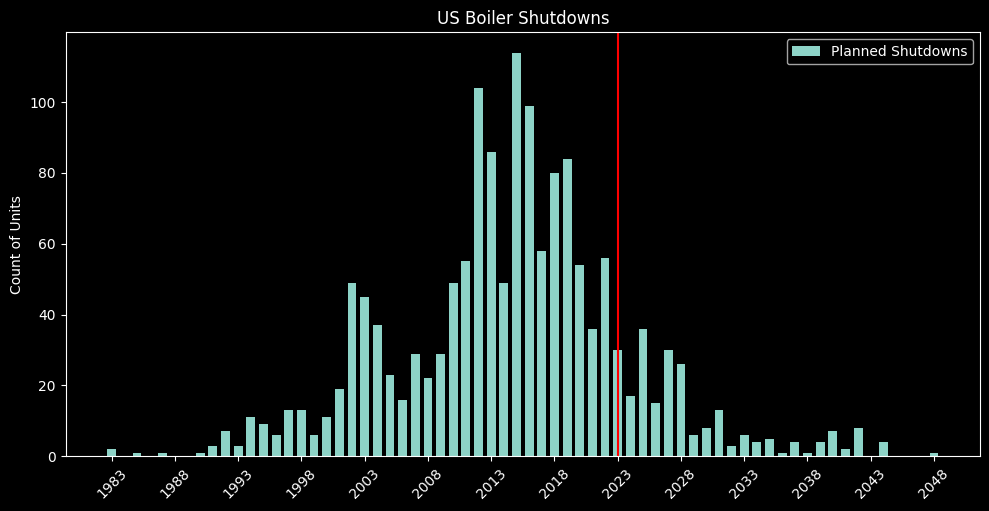

In [48]:
fig, ax = plt.subplots()

x = shutdowns_by_yr["SHUTDOWN_yr"]
y = shutdowns_by_yr["UNIT_ID"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Planned Shutdowns')
ax.set_title('US Boiler Shutdowns')
ax.set_ylabel('Count of Units')
ax.set_xticks(x)
#ax.set_xticklabels(shutdowns_by_yr["SHUTDOWN_yr"])
ax.legend()

fig.tight_layout()

plt.axvline(x=2023, c='r')
plt.xticks(np.arange(min(x), max(x)+1, 5))

plt.xticks(rotation=45)
plt.show()

In [49]:
operational_boilers_shutdown = operational_us_boilers_df.groupby(['SHUTDOWN_yr'])['UNIT_ID'].nunique().to_frame().reset_index()

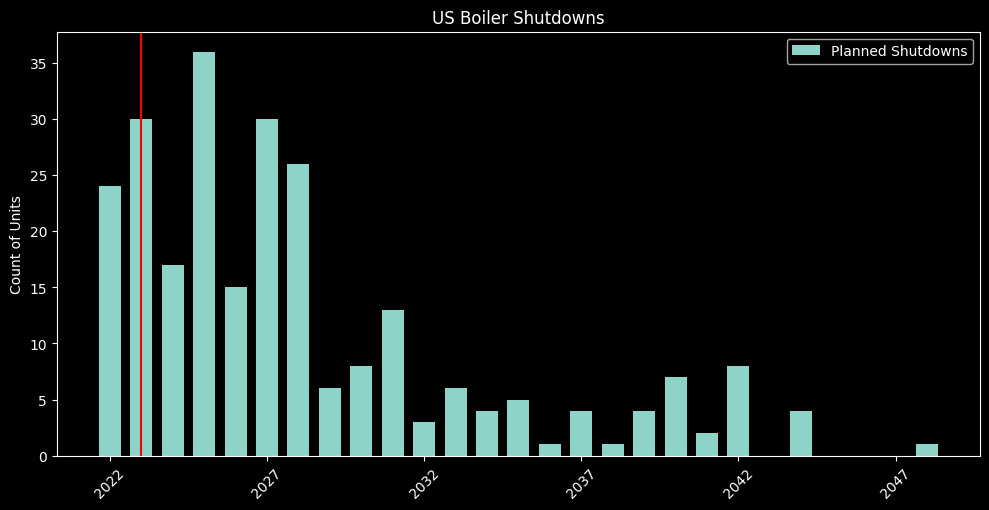

In [50]:
fig, ax = plt.subplots()

x = operational_boilers_shutdown["SHUTDOWN_yr"]
y = operational_boilers_shutdown["UNIT_ID"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Planned Shutdowns')
ax.set_title('US Boiler Shutdowns')
ax.set_ylabel('Count of Units')
ax.set_xticks(x)
#ax.set_xticklabels(shutdowns_by_yr["SHUTDOWN_yr"])
ax.legend()

fig.tight_layout()

plt.axvline(x=2023, c='r')
plt.xticks(np.arange(min(x), max(x)+1, 5))

plt.xticks(rotation=45)
plt.show()

In [51]:
boiler_status = us_boilers_df.groupby(['U_STATUS'])['UNIT_ID'].nunique().to_frame().reset_index()

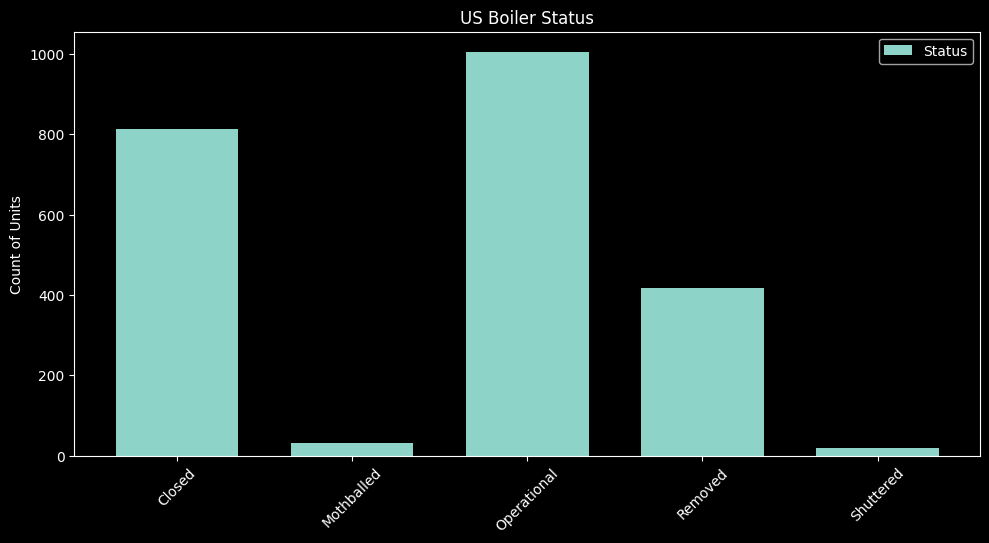

In [52]:
fig, ax = plt.subplots()

x = boiler_status["U_STATUS"]
y = boiler_status["UNIT_ID"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Status')
ax.set_title('US Boiler Status')
ax.set_ylabel('Count of Units')
ax.set_xticks(x)
#ax.set_xticklabels(x)
ax.legend()

fig.tight_layout()

#plt.axvline(x=2023, c='r')
#plt.xticks(np.arange(min(x), max(x)+1, 5))

plt.xticks(rotation=45)
plt.show()

Mothballed power plants
Power plant layup or mothballing is one of the methods that plant operators can apply to prevent corrosive damage and ensure the preservation of various assets. When equipment and plants are mothballed, the organization maintains the service life of these facilities by employing various protective measures.

https://www.bryair.com/news-and-events/articles/mothballing-as-an-effective-power-plant-layup/#:~:text=Power%20plant%20layup%20or%20mothballing,by%20employing%20various%20protective%20measures.

In [53]:
us_boilers_byparent = operational_us_boilers_df.groupby(['PARENTNAME'])['UNIT_ID'].nunique().to_frame().sort_values(by='UNIT_ID', ascending=False).reset_index()

In [54]:
us_boilers_byparent.head(10)

,PARENTNAME,UNIT_ID
0,American Electric Power Company Incorporated,43
1,Vistra Energy Corporation,41
2,Xcel Energy Incorporated,35
3,Southern Company,29
4,Duke Energy Corporation,29
5,Berkshire Hathaway Incorporated,27
6,Covanta Holding Corporation,26
7,Tennessee Valley Authority,25
8,NRG Energy Incorporated,23
9,Entergy Corporation,21


In [55]:
us_boilers_byparent.UNIT_ID.sum()

1005

In [56]:
us_boilers_df.groupby(['FUEL_GROUP', 'PRIM_FUEL', 'SECND_FUEL'])['UNIT_ID'].nunique().to_frame().sort_values(by='UNIT_ID', ascending=False).head(20)

UNIT_ID
FUEL_GROUP       PRIM_FUEL                 SECND_FUEL                               
Natural Gas      Natural Gas               Fuel Oil No. 2 Distillate Diesel      209
                                           Fuel Oil No. 6 Residual               148
Coal             Coal Subbituminous        Natural Gas                           142
                 Coal Bituminous           Fuel Oil No. 2 Distillate Diesel      131
                                           Natural Gas                           115
                 Coal Subbituminous        Coal Bituminous                       112
                 Coal Bituminous           Coal Subbituminous                     61
                 Coal Subbituminous        Fuel Oil No. 2 Distillate Diesel       55
Renewable Energy Waste (solid/sludge)      Natural Gas                            46
Fuel Oil         Fuel Oil No. 6 Residual   Natural Gas                            43
Coal             Coal Bituminous           Petroleum Coke                         30
Natural Gas      Combined Cycle Waste Heat Natural Gas                            22
Fuel Oil         Fuel Oil No. 6 Residual   Fuel Oil No. 2 Distillate Diesel       21
Renewable Energy Waste (solid/sludge)      Fuel Oil No. 2 Distillate Diesel       19
Natural Gas      Natural Gas               Fuel Oil No. 5 Residual                17
Coal             Coal Bituminous           Fuel Oil No. 6 Residual                14
Natural Gas      Natural Gas               Fuel Oil                               14
Coal             Coal Lignite              Coal Subbituminous                     13
                 Coal Bituminous           Coal Waste                             12
Renewable Energy Wood                      Natural Gas                            12

In [57]:
operational_us_boilers_df.groupby(['FUEL_GROUP'])['UNIT_ID'].nunique().to_frame().sort_values(by='UNIT_ID', ascending=False)

,UNIT_ID
FUEL_GROUP,
Coal,472
Natural Gas,350
Renewable Energy,106
Fuel Oil,77


### Source 4:

Portal Service ...


portalservice_power_units.json

In [58]:
with open(r'../data/raw_data/portalservice_power_inspections_2022.json') as json_data:
    d = json.loads(json_data.read())
    json_data.close()

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw_data/portalservice_power_inspections_2022.json'

In [ ]:
portalservice_power_inspections_2022_df = pd.json_normalize(d)

In [ ]:
portalservice_power_inspections_2022_df.head(1)

In [ ]:
portalservice_power_inspections_2022_df.columns

In [ ]:
ref_df = portalservice_power_inspections_2022_df.loc[:,(
    'Customer.name',
    'Location.region',
    'Location.name',
    'Location.city',
    'Location.slack_channel',
    'Unit.slug',
    'Unit.id',
    'Unit.name',
    'Unit.retirement_date',
    'Unit.fuel_type',
    'Unit.capacity',
    'Unit.total_tubes',
    'Component.slug',
    'Component.name',
    'Component.tube_diameter', 
    'Component.tube_spacing',
    'Component.shell_diameter',
    'Component.component_type',
    'Inspection.slug',
    'Inspection.date',
    'Inspection.ndt_method_type',
    'Inspection.inspection_type',
)]

In [ ]:
ref_df.head(1)

In [ ]:
ref_df.shape

In [ ]:
min(ref_df['Inspection.date'])

In [ ]:
max(ref_df['Inspection.date'])

In [ ]:
set(ref_df['Component.component_type'])

In [ ]:
ref_df[ref_df['Customer.name']=='Consolidated Edison Company of New York (Corporate)']

In [ ]:
portalservice_power_inspections_2022_df.shape

# For Wolpa



In [ ]:
wolpas_df = pd.read_csv(r'../data/raw_data/unit_slug_mappings.csv')

In [ ]:
wolpas_df.head()

In [ ]:
wolpas_df.shape

In [ ]:
wolpas_df[~wolpas_df.GECKO_UNIT_SLUG.isnull()].shape

In [ ]:
filtered_wolpa_df = wolpas_df[~wolpas_df['GECKO_UNIT_SLUG'].isnull()]

In [ ]:
filtered_wolpa_df.shape

In [ ]:
filtered_wolpa_df.head()

In [ ]:
slug_maps = ref_df.loc[:,('Inspection.slug', 'Unit.slug')]

In [ ]:
wolpa_df_inspection_slugs = filtered_wolpa_df.merge(slug_maps, how='left', left_on='GECKO_UNIT_SLUG', right_on='Unit.slug')

In [ ]:
wolpa_df_inspection_slugs.head()

## Get All PBI

In [ ]:
all_pbi_to_check_df = pd.read_csv('../data/outputs/all_pbi.csv')

In [ ]:
all_pbi_to_check_df.head(1)

In [ ]:
all_pbi_to_check_df.shape

## Get Slopes Components Only

In [ ]:
all_pbi_to_check_df['Component_type'] = all_pbi_to_check_df['Component.slug'].apply(lambda x: determine_component(x))

In [ ]:
set(all_pbi_to_check_df['Component_type'])

In [ ]:
all_pbi_to_check_df.groupby(['Component_type'])['Component.slug'].nunique().to_frame()

In [ ]:
slope_slugs_df = all_pbi_to_check_df[all_pbi_to_check_df['Component_type']=='Slopes']

In [ ]:
slope_slugs_df.head()

In [ ]:
slope_slugs_df.groupby(['Customer.name', 'Location.name'])['Component.slug'].nunique()

In [ ]:
slope_slugs_df.rename(columns={
    'Inspection.slug': 'slug',	
    'Component.wall_nominal_thickness': 'nominal',
}, inplace=True)

In [ ]:
slope_slugs_df['nominal'].isnull().sum()

In [ ]:
slope_slugs_df.shape[0]

In [ ]:
slope_slugs_df[slope_slugs_df['nominal']==0.012]

In [ ]:
slopes_df = slope_slugs_df[(~slope_slugs_df.nominal.isnull()) & (slope_slugs_df.nominal!=0.012)]

In [ ]:
set(slopes_df['nominal'])

In [ ]:
slopes_df.shape

In [ ]:
slopes_df[slopes_df['nominal']<0.22].shape

In [ ]:
slopes_df.reset_index(inplace=True)

In [ ]:
slopes_histogram_df, slopes_hist_error_slug_list = get_thickness_histogram(slopes_df)

In [ ]:
slopes_comb_df = slopes_df.merge(slopes_histogram_df, how='inner', on=['slug', 'nominal'])

In [ ]:
slopes_comb_df.drop(columns='index', inplace=True)

In [ ]:
slopes_comb_df.head()

In [ ]:
slopes_comb_df.shape

In [ ]:
# slopes_comb_df.to_csv('../data/outputs/raw_slopes.csv')

In [ ]:
slopes_comb_df[(slopes_comb_df['Customer.name'].isin(POWER_CUST_LIST))].shape

In [ ]:
slopes_comb_df[(slopes_comb_df['Customer.name'].isin(POWER_CUST_LIST)) & (slopes_df['nominal']<0.24)].shape

In [ ]:
slopes_comb_df[(slopes_comb_df['Customer.name'].isin(POWER_CUST_LIST)) & (slopes_df['nominal']<0.22)].shape

In [ ]:
slopes_comb_df.columns

In [ ]:
slopes_comb_df.groupby(['Component_type'])[
    'Bins w 10% Loss',
    'Bins w 20% Loss',
    'Bins w 30% Loss',
    'Bins w 40% Loss',
    'Bins w 50% Loss',
    'Bins w 60% Loss',
    'Bins w 70% Loss',
    'Bins w 80% Loss',
    'Bins w 90% Loss',
    'nominal',
    'tubes_inspected',
    'bins_collected'
].median()

In [ ]:
slopes_comb_df[(slopes_comb_df['Customer.name'].isin(POWER_CUST_LIST))].groupby(['Component_type'])[
    'Bins w 10% Loss',
    'Bins w 20% Loss',
    'Bins w 30% Loss',
    'Bins w 40% Loss',
    'Bins w 50% Loss',
    'Bins w 60% Loss',
    'Bins w 70% Loss',
    'Bins w 80% Loss',
    'Bins w 90% Loss',
    'nominal',
    'tubes_inspected',
    'bins_collected'
].median()

In [ ]:
slopes_comb_df[(slopes_comb_df['Customer.name'].isin(POWER_CUST_LIST)) & (slopes_df['nominal']<0.22)].groupby(['Component_type'])[
    'Bins w 10% Loss',
    'Bins w 20% Loss',
    'Bins w 30% Loss',
    'Bins w 40% Loss',
    'Bins w 50% Loss',
    'Bins w 60% Loss',
    'Bins w 70% Loss',
    'Bins w 80% Loss',
    'Bins w 90% Loss',
    'nominal',
    'tubes_inspected',
    'bins_collected'
].median()

In [ ]:
slopes_comb_df[(slopes_comb_df['Customer.name'].isin(POWER_CUST_LIST)) & (slopes_df['nominal']>=0.24)].shape

In [ ]:
slopes_comb_df[(slopes_comb_df['Customer.name'].isin(POWER_CUST_LIST)) & (slopes_df['nominal']>0.24)].groupby(['Component_type'])[
    'Bins w 10% Loss',
    'Bins w 20% Loss',
    'Bins w 30% Loss',
    'Bins w 40% Loss',
    'Bins w 50% Loss',
    'Bins w 60% Loss',
    'Bins w 70% Loss',
    'Bins w 80% Loss',
    'Bins w 90% Loss',
    'nominal',
    'tubes_inspected',
    'bins_collected'
].median()

In [ ]:
slopes_comb_df[(slopes_comb_df['Customer.name'].isin(POWER_CUST_LIST)) & (slopes_df['nominal']<=0.24)].shape

In [ ]:
slopes_comb_df[(slopes_comb_df['Customer.name'].isin(POWER_CUST_LIST)) & (slopes_df['nominal']<=0.24)].groupby(['Component_type'])[
    'Bins w 10% Loss',
    'Bins w 20% Loss',
    'Bins w 30% Loss',
    'Bins w 40% Loss',
    'Bins w 50% Loss',
    'Bins w 60% Loss',
    'Bins w 70% Loss',
    'Bins w 80% Loss',
    'Bins w 90% Loss',
    'nominal',
    'tubes_inspected',
    'bins_collected'
].median()

In [ ]:
slopes_comb_df[slopes_comb_df['Customer.name']=='Duke Energy']

In [ ]:
IIR_ID_slopes_df = pd.read_csv('../data/intermediate/slopes_wIIR_id.csv')

In [ ]:
IIR_ID_slopes_df.head(1)

In [ ]:
IIR_ID_slopes_df.IIR_UNIT_ID = IIR_ID_slopes_df.IIR_UNIT_ID.astype(int)

In [ ]:
us_boilers_df.head(1)

In [ ]:
enriched_slopes_aggs_df = IIR_ID_slopes_df.merge(us_boilers_df, how='left', left_on='IIR_UNIT_ID', right_on='UNIT_ID')

In [ ]:
enriched_slopes_aggs_df.head(1)

In [ ]:
enriched_slopes_aggs_df[(enriched_slopes_aggs_df['Customer.name'].isin(POWER_CUST_LIST)) & (enriched_slopes_aggs_df['nominal']<=0.24)].groupby(['FUEL_GROUP'])['slug'].nunique()

In [ ]:
enriched_slopes_aggs_df[(enriched_slopes_aggs_df['Customer.name'].isin(POWER_CUST_LIST)) & (enriched_slopes_aggs_df['nominal']<=0.24)].groupby(['PRIM_FUEL'])['slug'].nunique()

In [ ]:
enriched_slopes_aggs_df.shape

In [ ]:
enriched_slopes_aggs_df.to_csv('../data/outputs/agg_slopes_data.csv')

In [ ]:
all_pbi_to_check_df.rename(columns={
    'Inspection.slug': 'slug',	
    'Component.wall_nominal_thickness': 'nominal',
}, inplace=True)

null_nominals = all_pbi_to_check_df['nominal'].isnull().sum()
null_nominals_aspercentage = round(100*null_nominals/all_pbi_to_check_df.shape[0], 2)

median_nominal = all_pbi_to_check_df['nominal'].median()

print('Nominals with null value: {} , or {}% of total'.format(null_nominals, null_nominals_aspercentage))
print('Nominal used to fillna:  {}'.format(median_nominal))

all_pbi_to_check_df['nominal'].fillna(median_nominal, inplace=True)

## Error checking and handling

In [ ]:
len(error_slug_list)

In [ ]:
error_slug_list

In [ ]:
error_df = ref_df[ref_df['Inspection.slug'].isin(error_slug_list)]

In [ ]:
dominion_mtstorm_unit_1 = ['20220919-072202', '20220919-f40fdc', '20220919-35548d', '20220917-b520a5']
great_river_spiritwood_unit_1 = ['20220507-caec3a', '20220507-182a26', '20220506-c90d1d', '20220506-396ef9']
aes_warrior_run_unit_1 = ['20220509-27e470', '20220509-addaf6', '20220509-0849bd']

In [ ]:
unchecked_error_df = error_df[
    (~error_df['Inspection.slug'].isin(dominion_mtstorm_unit_1)) & 
    (~error_df['Inspection.slug'].isin(great_river_spiritwood_unit_1)) &
    (~error_df['Inspection.slug'].isin(aes_warrior_run_unit_1))
]

In [ ]:
unchecked_error_df

In [ ]:
#get_inspection_df('20220310-990386')

## Davos - Jake

In [ ]:
jake_davos_threshold = 0.6
# jake_davos_df, davos_error_slug_list = check_thickness(all_pbi_to_check_df, jake_davos_threshold)

In [ ]:
# ratio = 100*(jake_davos_df[jake_davos_df.critical_bins != 0].shape[0] / jake_davos_df.shape[0])

In [ ]:
# ratio

In [ ]:
round(ratio, 2)

In [ ]:
len(davos_error_slug_list)

# Use Histogram Generator

In [ ]:
# histogram_df, hist_error_slug_list = get_thickness_histogram(all_pbi_to_check_df)

In [ ]:
histogram_df.head()

In [ ]:
histogram_df.shape

In [ ]:
len(hist_error_slug_list)

In [ ]:
enriched_hist_df = histogram_df.merge(all_pbi_to_check_df.loc[:,(
    'slug',
    'Customer.name',
    'Location.name',
    'Location.city',
    'Unit.name',
    'Unit.slug',
    'Component.slug',
)], how='left', on='slug')

In [ ]:
enriched_hist_df.head(1)

In [ ]:
enriched_hist_df.shape

In [ ]:
clean_hist_df = enriched_hist_df.loc[:, (
    'Customer.name',
    'Location.name',
    'Location.city',
    'Unit.name',
    'Unit.slug',
    'Component.slug',
    'slug',
    'nominal',
    'min_t',
    'max_t',
    'tubes_inspected',
    'bins_collected',
    'Tubes w 10% Loss',
    'Tubes w 20% Loss',
    'Tubes w 30% Loss',
    'Tubes w 40% Loss',
    'Tubes w 50% Loss',
    'Tubes w 60% Loss',
    'Tubes w 70% Loss',
    'Tubes w 80% Loss',
    'Tubes w 90% Loss',
    'Bins w 10% Loss',
    'Bins w 20% Loss',
    'Bins w 30% Loss',
    'Bins w 40% Loss',
    'Bins w 50% Loss',
    'Bins w 60% Loss',
    'Bins w 70% Loss',
    'Bins w 80% Loss',
    'Bins w 90% Loss'
)]

In [ ]:
# NOTE this relies on an assume 3in bin size
clean_hist_df['tube_feet_inspected'] = clean_hist_df['bins_collected']*3/12 # convert to tube feet ?

In [ ]:
clean_hist_df.head(1)

In [ ]:
clean_hist_df.shape

## Filter for just the power customers identified

In [ ]:
power_hist_df = clean_hist_df[clean_hist_df['Customer.name'].isin(POWER_CUST_LIST)]

In [ ]:
site_grouped_hist = clean_hist_df.groupby(['Customer.name', 'Location.name'])[
    'Tubes w 10% Loss',
    'Tubes w 20% Loss',
    'Tubes w 30% Loss',
    'Tubes w 40% Loss',
    'Tubes w 50% Loss',
    'Tubes w 60% Loss',
    'Tubes w 70% Loss',
    'Tubes w 80% Loss',
    'Tubes w 90% Loss',
    'Bins w 10% Loss',
    'Bins w 20% Loss',
    'Bins w 30% Loss',
    'Bins w 40% Loss',
    'Bins w 50% Loss',
    'Bins w 60% Loss',
    'Bins w 70% Loss',
    'Bins w 80% Loss',
    'Bins w 90% Loss',
    'tube_feet_inspected',
    'tubes_inspected',	
    'bins_collected'
].sum()

In [ ]:
site_grouped_hist.head(25)

In [ ]:
unit_grouped_hist = clean_hist_df.groupby(['Customer.name', 'Location.name', 'Unit.name'])[
    'Tubes w 10% Loss',
    'Tubes w 20% Loss',
    'Tubes w 30% Loss',
    'Tubes w 40% Loss',
    'Tubes w 50% Loss',
    'Tubes w 60% Loss',
    'Tubes w 70% Loss',
    'Tubes w 80% Loss',
    'Tubes w 90% Loss',
    'Bins w 10% Loss',
    'Bins w 20% Loss',
    'Bins w 30% Loss',
    'Bins w 40% Loss',
    'Bins w 50% Loss',
    'Bins w 60% Loss',
    'Bins w 70% Loss',
    'Bins w 80% Loss',
    'Bins w 90% Loss',
    'tube_feet_inspected',
    'tubes_inspected',	
    'bins_collected'
].sum()

In [ ]:
unit_grouped_hist.head()

In [ ]:
unit_grouped_hist[unit_grouped_hist['Bins w 40% Loss']!=0].shape

In [ ]:
unit_grouped_hist[unit_grouped_hist['Bins w 50% Loss']!=0].shape

In [ ]:
unit_grouped_hist[unit_grouped_hist['Bins w 60% Loss']!=0].shape

In [ ]:
unit_grouped_hist.shape

Save unit_grouped_hist as a csv

In [ ]:
# unit_grouped_hist.reset_index().to_csv('data/outputs/unit_grouped_hist.csv')

In [ ]:
component_grouped_hist = clean_hist_df.groupby(['Customer.name', 'Location.name', 'Unit.name', 'Component.slug'])[
    'Tubes w 10% Loss',
    'Tubes w 20% Loss',
    'Tubes w 30% Loss',
    'Tubes w 40% Loss',
    'Tubes w 50% Loss',
    'Tubes w 60% Loss',
    'Tubes w 70% Loss',
    'Tubes w 80% Loss',
    'Tubes w 90% Loss',
    'Bins w 10% Loss',
    'Bins w 20% Loss',
    'Bins w 30% Loss',
    'Bins w 40% Loss',
    'Bins w 50% Loss',
    'Bins w 60% Loss',
    'Bins w 70% Loss',
    'Bins w 80% Loss',
    'Bins w 90% Loss',
    'tube_feet_inspected',
    'tubes_inspected',	
    'bins_collected'
].sum()

In [ ]:
component_grouped_hist.tail(5)

In [ ]:
component_grouped_hist.shape

My Thoughts:

- we probably want to find a better way to combine aggregates for the same component slug, we currently sum, but if those are 2 separate inspections did they cover the same section ?  Were they at different dates ?  there is more nuance that is not being addressed here

- how could we identify weld overlay ?
- how can we incorporate the partial inspections into a better model

David Wolpa
 
Here are my ideas to increase the value of this data asset:

1. Group the slugs into waterwalls and slopes
2. include partial boiler scans (vs just relying on full scans) by grouping data into critical bins per 1000 (or some other number) inspected. This makes our sample size much larger improving accuracy and ability to slice data…
3. Add meta data like boiler type, and weld overlay amount that we can later filter on to produce most accurate comparisons groups
4. bring into radar like y'all are discussing to hydrate initial predictions before we even step foot into a specific boiler
5. The sales team already has a tool that calculates how many tube feet a specific boiler has based on eng drawings so we can use that to normalize what we expect to find in specific boiler to our data set that is orgianized by critical bins per 1000 bins inspected

## Bowen Analysis

In [ ]:
bowen_df = clean_hist_df[
    (clean_hist_df['Customer.name'].str.contains('Southern Co')) & 
    (clean_hist_df['Location.name'].str.contains('Plant Bowen'))
]

In [ ]:
bowen_df.head(1)

In [ ]:
bowen_df.groupby(['Unit.name'])['slug'].nunique().to_frame()

In [ ]:
bowen_unit_1_df = bowen_df[bowen_df['Unit.name']=='Unit 1']

In [ ]:
bowen_unit_1_df

In [ ]:
# bowen_unit_1_df.to_csv('../data/outputs/bowen.csv')

In [ ]:
hist_values_sum = unit_grouped_hist.sum()
hist_cols = unit_grouped_hist.columns

In [ ]:
hist_values_median = unit_grouped_hist.median()

In [ ]:
hist_values_mean = unit_grouped_hist.mean()

In [ ]:
hist_cols

In [ ]:
fig, ax = plt.subplots()

x = hist_cols[9:18]
y = hist_values_sum[9:18]
width =0.7

rects1 = ax.barh(x, y, width, label = 'Status')
ax.set_title('US Boiler Wall Loss Histogram')
ax.set_ylabel('Count of Bins')
#ax.set_xticks(x)
#ax.set_xticklabels(x)
ax.legend()

fig.tight_layout()

#plt.axvline(x=2023, c='r')
#plt.xticks(np.arange(min(x), max(x)+1, 5))

plt.xticks(rotation=0)
plt.show()

In [ ]:
fig, ax = plt.subplots()

x = hist_cols[0:9]
y = hist_values_sum[9:18]
width =0.7

rects1 = ax.barh(x, y, width, label = 'Status')
ax.set_title('US Boiler Wall Loss Histogram')
ax.set_ylabel('Count of Tubes')
#ax.set_xticks(x)
#ax.set_xticklabels(x)
ax.legend()

fig.tight_layout()

#plt.axvline(x=2023, c='r')
#plt.xticks(np.arange(min(x), max(x)+1, 5))

plt.xticks(rotation=0)
plt.show()

In [ ]:
fig, ax = plt.subplots()

x = hist_cols[9:18]
y = hist_values_median[9:18]
width =0.7

rects1 = ax.barh(x, y, width, label = 'Status')
ax.set_title('US Boiler Wall Loss Histogram')
ax.set_ylabel('Count of Bins')
#ax.set_xticks(x)
#ax.set_xticklabels(x)
ax.legend()

fig.tight_layout()

#plt.axvline(x=2023, c='r')
#plt.xticks(np.arange(min(x), max(x)+1, 5))

plt.xticks(rotation=0)
plt.show()

In [ ]:
fig, ax = plt.subplots()

x = hist_cols[0:9]
y = hist_values_median[0:9]
width =0.7

rects1 = ax.barh(x, y, width, label = 'Status')
ax.set_title('US Boiler Wall Loss Histogram')
ax.set_ylabel('Count of Bins')
#ax.set_xticks(x)
#ax.set_xticklabels(x)
ax.legend()

fig.tight_layout()

#plt.axvline(x=2023, c='r')
#plt.xticks(np.arange(min(x), max(x)+1, 5))

plt.xticks(rotation=0)
plt.show()

In [ ]:
fig, ax = plt.subplots()

x = hist_cols[9:18]
y = hist_values_mean[9:18]
width =0.7

rects1 = ax.barh(x, y, width, label = 'Status')
ax.set_title('US Boiler Wall Loss Histogram')
ax.set_ylabel('Count of Bins')
#ax.set_xticks(x)
#ax.set_xticklabels(x)
ax.legend()

fig.tight_layout()

#plt.axvline(x=2023, c='r')
#plt.xticks(np.arange(min(x), max(x)+1, 5))

plt.xticks(rotation=0)
plt.show()

In [ ]:
fig, ax = plt.subplots()

x = hist_cols[0:9]
y = hist_values_mean[0:9]
width =0.7

rects1 = ax.barh(x, y, width, label = 'Status')
ax.set_title('US Boiler Wall Loss Histogram')
ax.set_ylabel('Count of Bins')
#ax.set_xticks(x)
#ax.set_xticklabels(x)
ax.legend()

fig.tight_layout()

#plt.axvline(x=2023, c='r')
#plt.xticks(np.arange(min(x), max(x)+1, 5))

plt.xticks(rotation=0)
plt.show()

In [ ]:
unit_grouped_hist.head(1)

In [ ]:
component_grouped_hist.head(1)

In [ ]:
ref_df.head(1)

## Merge crit df and ref df into comb_df

In [ ]:
comb_df = unit_grouped_hist.merge(ref_df, how='left', on=[
    'Customer.name', 
    'Location.name',
    'Unit.name'
])

In [ ]:
comb_df.head()

In [ ]:
component_comb_df = component_grouped_hist.merge(ref_df, how='left', on=[
    'Customer.name', 
    'Location.name',
    'Unit.name',
    'Component.slug'
])

In [ ]:
component_comb_df.tail()

In [ ]:
def determine_component(string):
    """
    Take a component slug and derive the component type
    """
    component_type = 'Other'
    
    if 'slopes' in str(string).lower():
        component_type = 'Slopes'
    if 'walls' in str(string).lower():
        component_type = 'Walls'
    
    return component_type

In [ ]:
component_comb_df['Component_type'] = component_comb_df['Component.name'].apply(lambda x: determine_component(x))

Ideas here:

- if string component.name contains wall
- if string component name contains slope

In [ ]:
set(component_comb_df['Component.name'])

In [ ]:
set(component_comb_df['Component_type'])

In [ ]:
component_comb_df.groupby(['Component_type'])['Component.slug'].nunique().to_frame()

In [ ]:
with open(r'../data/raw_data/power_boiler_inspections_pre2019.json') as json_data:
    d = json.loads(json_data.read())
    json_data.close()

In [ ]:
power_boiler_inspections19_df = pd.json_normalize(d)

In [ ]:
power_boiler_inspections19_df['Unit.id'].nunique()

In [ ]:
power_boiler_inspections19_df.head(1)

In [ ]:
min(power_boiler_inspections19_df['Inspection.date'])

In [ ]:
max(power_boiler_inspections19_df['Inspection.date'])

In [ ]:
filtered_pre19_power_boiler_inspections_df = power_boiler_inspections19_df.loc[:, (
    'Inspection.slug', 
    'Component.wall_nominal_thickness', 
    'Component.wall_warning_thickness', 
    'Component.coating_nominal_thickness',
    'Component.slug',
    'Unit.name',
    'Unit.slug',
    'Location.name',
    'Location.city',
    'Customer.name'
)]

In [ ]:
with open(r'../data/raw_data/power_boiler_inspections.json') as json_data:
    d = json.loads(json_data.read())
    json_data.close()

In [ ]:
power_boiler_inspections_df = pd.json_normalize(d)

In [ ]:
power_boiler_inspections_df.head(1)

In [ ]:
filtered_power_boiler_inspections_df = power_boiler_inspections_df.loc[:, (
    'Inspection.slug', 
    'Component.wall_nominal_thickness', 
    'Component.wall_warning_thickness', 
    'Component.coating_nominal_thickness',
    'Component.slug',
    'Unit.name',
    'Unit.slug',
    'Location.name',
    'Location.city',
    'Customer.name'
)]

In [ ]:
all_pbi_df = pd.concat([filtered_power_boiler_inspections_df, filtered_pre19_power_boiler_inspections_df])

In [ ]:
all_pbi_df.head(1)

In [ ]:
all_pbi_ordered_df = all_pbi_df.loc[:,(
    'Customer.name', 
    'Location.name', 
    'Location.city',
    'Location.region',
    'Location.slack_channel',
    'Unit.id',
    'Unit.name', 
    'Unit.slug',
    'Unit.retirement_date',
    'Unit.fuel_type',
    'Unit.capacity',
    'Unit.total_tubes',
    'Component.slug', 
    'Component.component_type',
    'Component.wall_nominal_thickness', 
    'Component.wall_warning_thickness', 
    'Component.coating_nominal_thickness',
    'Component.tube_diameter', 
    'Component.tube_spacing',
    'Component.shell_diameter',
    'Inspection.slug',
    'Inspection.date',
    'Inspection.ndt_method_type',
    'Inspection.inspection_type'
)].drop_duplicates()

In [ ]:
all_pbi_ordered_df.head(1)

In [ ]:
all_pbi_ordered_df.shape

In [ ]:
# all_pbi_ordered_df.to_csv('../data/outputs/all_pbi.csv')

In [ ]:
ref_df = portalservice_power_inspections_2022_df.loc[:,(

    'Inspection.date',
    'Inspection.ndt_method_type',
    'Inspection.inspection_type',

    'Component.tube_diameter', 
    'Component.tube_spacing',
    'Component.shell_diameter',
    'Component.component_type',

)]

In [ ]:
names_df = all_pbi_ordered_df.loc[:, (
    'Customer.name', 
    'Location.name', 
    'Location.city', 
    'Unit.name', 
    'Unit.slug'
)].drop_duplicates()

In [ ]:
names_df.shape

In [ ]:
power_parents = [
    'AEP',
    'AES',
    'ALCOA',
    'Dominion',
    'Duke Energy',
    'East Kentucky Power Coop (EKPC)',
    'Hallador Power Company',
    'NRG',
    'Southern Co'
]

In [ ]:
power_names_df = names_df[names_df['Customer.name'].isin(power_parents)]

In [ ]:
power_names_df.shape

In [ ]:
power_names_df.sort_values(['Customer.name', 'Location.name', 'Location.city', 'Unit.name'])

In [ ]:
power_boiler_inspections_df['Unit.id'].nunique()

In [ ]:
power_boiler_inspections_df['Inspection.id'].nunique()

In [ ]:
power_boiler_inspections_df.groupby([])

In [ ]:
aep_month_outage_df.head()

In [ ]:
duke_month_outages_df.head()

In [ ]:
aep_month_outage_df.rename(columns={'Event Start Timestamp': 'Event Count'}, inplace=True)
duke_month_outages_df.rename(columns={'Event ID': 'Event Count'}, inplace=True)
aep_month_outage_df['Utility'] = 'AEP'
duke_month_outages_df['Utility'] = 'Duke'

In [ ]:
eia_df = pd.read_csv(r'../data/raw_data/EIA.csv')

In [ ]:
eia_df.head()

In [ ]:
eia_df.shape

In [ ]:
eia_df['Year'] = eia_df['YYYYMM'].astype(str).str[0:4]
eia_df['Month'] = eia_df['YYYYMM'].astype(str).str[4:6]

In [ ]:
set(eia_df['Month'])

In [ ]:
recent_eia_df = eia_df[eia_df['Year'].astype(int) > 2000]

In [ ]:
recent_eia_df.shape

In [ ]:
set(recent_eia_df['Month'])

In [ ]:
set(recent_eia_df["Description"])

In [ ]:
keep_cols = ['Total Primary Energy Consumption',
 'Total Primary Energy Production']

In [ ]:
eia_prim_en_df = recent_eia_df[recent_eia_df["Description"].isin(keep_cols)]

In [ ]:
eia_prim_en_df.shape

In [ ]:
eia_prim_en_df.head()

In [ ]:
eia_2021_df = eia_prim_en_df[(eia_prim_en_df['Year']=='2021') & (eia_prim_en_df['Month']!='13')]

In [ ]:
eia_2021_df.head()

In [ ]:
eia_2021_consumption = eia_2021_df[eia_2021_df['Description']=='Total Primary Energy Consumption']
eia_2021_production = eia_2021_df[eia_2021_df['Description']=='Total Primary Energy Production']

In [ ]:
fig=plt.figure()
fig.show()
ax=fig.add_subplot(111)

ax.set_title('EIA US Energy Data')
ax.set_ylabel('Quadrillion Btu')
ax.set_ylim(eia_2021_consumption['Value'].min()-1,10)
ax.set_xlabel('Month')
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_xticklabels(eia_2021_consumption['Month'])


ax.plot(eia_2021_consumption['Month'].astype(int), eia_2021_consumption['Value'], c='r', label='Primary Energy Consumption')
#ax.plot(eia_2021_production['Month'].astype(int), eia_2021_production['Value'], c='g', label='Primary Energy Production')


plt.legend()
plt.draw()

In [ ]:
fig=plt.figure()
fig.show()
ax=fig.add_subplot(111)

ax.set_title('Tube Failures by Month')
ax.set_ylabel('Count of Tube Failures')
ax.set_xlabel('Month')
ax.set_xticks(aep_month_outage_df['Outage Month'])
ax.set_xticklabels(aep_month_outage_df['Outage Month'])


ax.plot(aep_month_outage_df['Outage Month'], aep_month_outage_df['Event Count'], c='r', label='AEP Tube Failures')
ax.plot(duke_month_outages_df['Outage Month'], duke_month_outages_df['Event Count'], c='b', label='Duke Tube Failures')


plt.legend()
plt.draw()

In [ ]:
comb_df.head()

In [ ]:
comb_df['Inspection.month'] = pd.to_datetime(comb_df['Inspection.date']).dt.month

In [ ]:
#set(comb_df['Inspection.month'])

In [ ]:
gecko_2022_inspections = comb_df.groupby(['Inspection.month'])['Inspection.slug'].nunique().to_frame().reset_index().rename(columns={'slug': 'inspections'})

In [ ]:
gecko_2022_inspections

In [ ]:
gecko_2022_inspections['Inspection.slug'].sum()

In [ ]:
#us_boilers_df.loc[:, ('MARKET_REG', 'PLANT_NAME')]

In [ ]:
us_boilers_df.loc[:, ('MARKET_REG', 'UNIT_STATE')]

In [ ]:
len(comb_df['Location.city'])

In [ ]:
len([city for city in comb_df['Location.city'] if city not in us_boilers_df['PHYS_CITY']])

In [ ]:
set(us_boilers_df['MARKET_REG'])

In [ ]:
markets_comb_df = comb_df.merge(us_boilers_df.loc[:, ('MARKET_REG', 'UNIT_STATE')], how='left', left_on='Location.region', right_on='UNIT_STATE')

In [ ]:
markets_comb_df.groupby(['MARKET_REG'])['Unit.slug'].nunique().to_frame()

In [ ]:
units_inspected_bycust = comb_df.groupby(['Customer.name'])['Unit.slug'].nunique().to_frame().reset_index()

In [ ]:
units_inspected_bycust['Unit.slug'].sum()

In [ ]:
## NOTE: in 2022 there were ZERO power inspections in February

In [ ]:
fig=plt.figure()
fig.show()
ax=fig.add_subplot(111)

ax.set_title('Gecko Power Inspections')
ax.set_ylabel('Count')
ax.set_xlabel('Month')
ax.set_xticks([1,3,4,5,6,7,8,9,10,11,12])
ax.set_xticklabels(gecko_2022_inspections['Inspection.month'])


ax.plot(gecko_2022_inspections['Inspection.month'], gecko_2022_inspections['Inspection.slug'], c='r', label='Gecko Power Inspections')


plt.legend()
plt.draw()

In [ ]:
with open(r'../data/raw_data/gecko_tank_shells.json', encoding="utf8") as json_data:
    d = json.loads(json_data.read())
    json_data.close()

In [ ]:
tank_shells_df = pd.json_normalize(d)

In [ ]:
tank_shells_df.head()

In [ ]:
tank_shells_df.columns

In [ ]:
tank_shells_df.shape

In [ ]:
def is_liquor(string):
    truth = False
    if 'liq' in string.lower():
        truth = True
        
    return truth

In [ ]:
test = 'liquor'

is_liquor(test)

In [ ]:
tank_shells_df[tank_shells_df['Unit.name'].apply(lambda x: is_liquor(x)) | tank_shells_df['Unit.slug'].apply(lambda x: is_liquor(x))].shape

In [ ]:
liq_tanks_df = tank_shells_df[tank_shells_df['Unit.name'].apply(lambda x: is_liquor(x)) | tank_shells_df['Unit.slug'].apply(lambda x: is_liquor(x))]

In [ ]:
liq_tanks_df

In [ ]:
liq_tanks_df[tank_shells_df['Customer.id']==8].shape

In [ ]:
liq_tanks_df[tank_shells_df['Customer.id']==8]

1648 tank shell inspections, 14 of those are liquor tanks, 6 are at GP